# Label CDK2 MD Conformations

- Check the [6_Label_CDK2_Crystal_Conformations](../1_Crystal_Structures/6_Label_CDK2_Crystal_Conformations.ipynb) notebook to see the criteria used to label a given CDK2 conformation.

## Load the CDK2 MD trajectories
- Evaluate the trajectories using batches
- Create the complementary dataframe using the conf. type and initial structure of each conformation


### Conformation types:

| Conformation Type | PDB Entry       |  Criteria |  
| :- |:------------- | :--
|**Active**|<mark style="background-color: #FFBAAD">1fin</mark>| Salt bridge between Lys33-Glu51 | 
|**Inactive** Src-Like|<mark style="background-color: #B0E6EA">4kku</mark>| No Lys33-Glu51 interaction |
|**Inactive** Open|<mark style="background-color: #FAE5BF">3pxf</mark>| $\alpha$C displacement from $\beta_4$ and $\beta_5$ sheets, forming an allosteric binding site |
|**Inactive** DFG-out|<mark style="background-color: #D5BFFA">5a14</mark>| Asp145 and Phe146 flipped & Phe146 oriented towards the pocket|


![CDK2_main_conformations](../1_Crystal_Structures/CDK2_main_conformations.png "CDK2 Confs.")

In [1]:
import pytraj as pyt
import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
from helper_modules.label_cdk2_confs import *

### Reference Structure

In [3]:
CRYS_DIR = '../../data/crystal_confs/'
ref_top_path = f'{CRYS_DIR}/pdb_modeled/1fin_A_mod.pdb'
ref_conf = pyt.load(ref_top_path, 
                    ref_top_path)
ref_conf

pytraj.Trajectory, 1 frames: 
Size: 0.000054 (GB)
<Topology: 2398 atoms, 298 residues, 1 mols, non-PBC>
           

In [4]:
import itertools as it

STRIDE_MD = 1
MD_DIR  = '../../data/md_trajectories/'
SYSTEMS = ['WAT', 'LIG', 'ETA', 'ISO', 'MAM']
PDB_IDS = ['1fin', '4fku', '3pxf', '5a14']
REPS    = [1, 2, 3]
# We can use the trajectories of the protein without hydrogens
# since the properties measured by `label_cdk2_conformations`
# don't require Hs
MD_FILE_BASENAME = 'md_protein_HvyAtms'

# # Perform the analysis per SYSTEM
# system = 'WAT'
# pdbid_reps = list(it.product(PDB_IDS, REPS))

# for pdbid, rep in pdbid_reps:
#     pdbid_traj_path = f'{MD_DIR}/{system}_systems/rep_{rep}/' +
#                       f'{pdb_id}/md/{MD_FILE_BASENAME}.trr'
#     # Load the trajectory
#     pdbid_rep_traj = pyt.load(pdbid_traj_path, 
#                               top    = ref_top_path,
#                               stride = STRIDE_MD)[1:-1]
#     # Perform the analysis
    

In [19]:
%%time
rep = 1
pdbid = '3pxf'
system = 'LIG'
pdbid_traj_path = f'{MD_DIR}/{system}_systems/rep_{rep}/' + \
                  f'{pdbid}/md/{MD_FILE_BASENAME}.trr'
    
pdbid_traj = pyt.load(pdbid_traj_path, 
                          top    = ref_top_path,
                          stride = STRIDE_MD)
# drop first conf as it belongs to the topology file
pdbid_traj = pdbid_traj[1:]
pdbid_traj

labels = label_cdk2_conformations(traj_obj = pdbid_traj, 
                         saltbridge_cutoff   = 7.0,
                         dfg_angle_cutoff    = 110.0,
                         aC_b4b5_dist_cutoff = 13.5,
                         dist_PHE146_GLY11   = 12.0
                         )
salt_bridge_33_51 = get_distance_ij(pdbid_traj, ':33@NZ', ':51@CD')
aC_displacement = get_geom_center_distance(pdbid_traj, ':46-57', ':66-72,75-81')
dfg_angle = np.absolute(get_phi_angle(pdbid_traj, residue = 145))

CPU times: user 21.8 s, sys: 746 ms, total: 22.5 s
Wall time: 24.1 s


In [20]:
labels

array(['inact_ope', 'inact_ope', 'inact_ope', ..., 'inact_src',
       'inact_src', 'inact_src'], dtype='<U9')

3pxf
inact_src    3451
inact_ope     549
Name: 0, dtype: int64


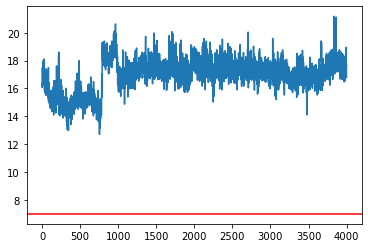

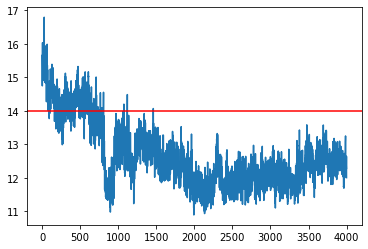

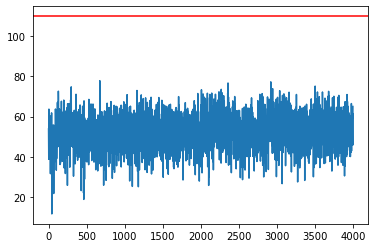

In [21]:
print(pdbid)
print(pd.DataFrame(labels)[0].value_counts())
plt.figure()
plt.plot(salt_bridge_33_51)
plt.axhline(y=7, c = 'red')

plt.figure()
plt.plot(aC_displacement)
plt.axhline(y=14, c = 'red')


plt.figure()
plt.plot(dfg_angle)
plt.axhline(y=110, c = 'red')

In [83]:
ang.to_ndarray()

array([56.136535  , 57.33153064, 54.88111363, ..., 51.70506007,
       55.96739951, 63.41737118])

In [77]:
labels

array(['active', 'active', 'undefined', ..., 'active', 'active',
       'undefined'], dtype='<U9')

In [117]:
import nglview as nv
view= nv.show_pytraj(pdbid_traj)
view.add_licorice(color = 'blue',
            selection = ':144 145 146')
view

NGLWidget(max_frame=3999)

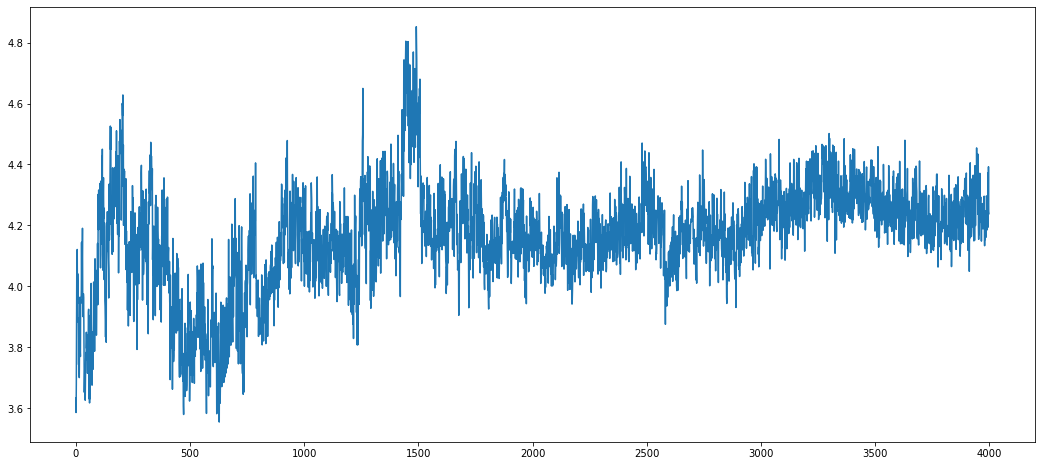

In [10]:
import matplotlib.pyplot as plt
rms = pyt.rmsd(pdbid_traj, mask = '@CA', ref = ref_conf)
plt.figure(figsize = (18, 8))
plt.plot(rms)

In [1]:
import pandas as pd

In [4]:
pdbid_confTypes = {'1fin': 'active', '4fku': 'inact_src', 
                       '3pxf': 'inact_ope', '5a14': 'dfg_out'}
rev_pdbid_confTypes = {v: k for k, v in pdbid_confTypes.items()}
pd.read_pickle('./kMedoid_MDconfsOnCRYSconfs_PisaniSelection').replace(rev_pdbid_confTypes)

,Conf.,MD-Protocol,Rep.,frame_number,1,2,3,k_label
0,1fin,ETA,1,115,17.272292,-2.436277,2.439217,22.0
1,1fin,ETA,1,310,13.174287,-0.894376,-1.738908,3.0
2,1fin,ETA,1,885,13.033538,-1.110930,0.578656,12.0
3,1fin,ETA,1,1180,13.711900,-2.325436,3.408733,27.0
4,1fin,ETA,1,1465,10.483861,0.405070,-2.781084,16.0
...,...,...,...,...,...,...,...,...
595,4fku,WAT,3,1565,-8.720376,1.050865,-0.157782,14.0
596,4fku,WAT,3,2560,-4.783447,-2.695735,7.748923,20.0
597,4fku,WAT,3,2595,-5.944090,-2.274076,4.074817,18.0
598,4fku,WAT,3,2865,-5.445765,-1.093705,5.848963,2.0
